In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
# Import the Movies dataset
movies = pd.read_csv('data/movie.csv')
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [5]:
# Import the ratings dataset
ratings = pd.read_csv('data/rating.csv')
ratings.head()

userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

avg_romance_rating  avg_scifi_rating
1                3.95              3.71
2                3.83              4.61
3                4.06              4.00
4                3.50              3.00
5                3.94              4.60

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  302


index  avg_romance_rating  avg_scifi_rating
0      4                3.50              3.00
1      8                3.95              3.18
2      9                4.00              2.67
3     15                3.33              3.00
4     18                3.88              2.45

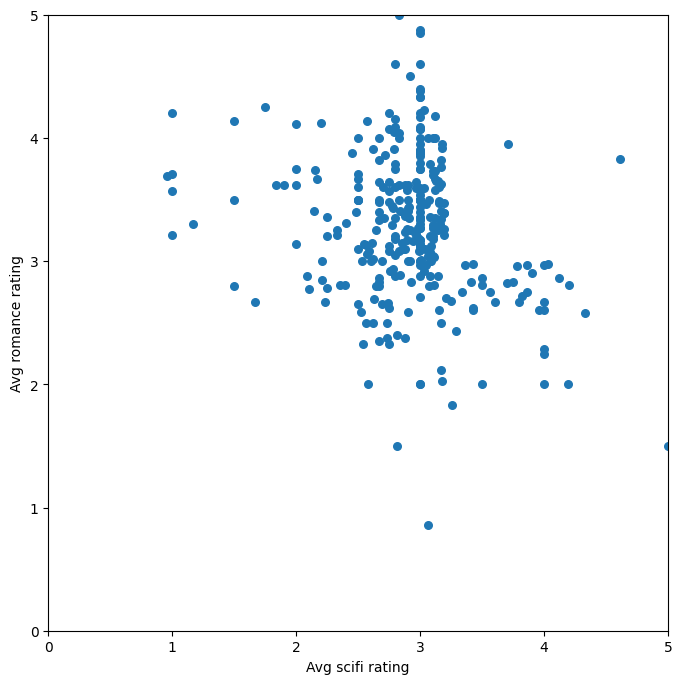

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

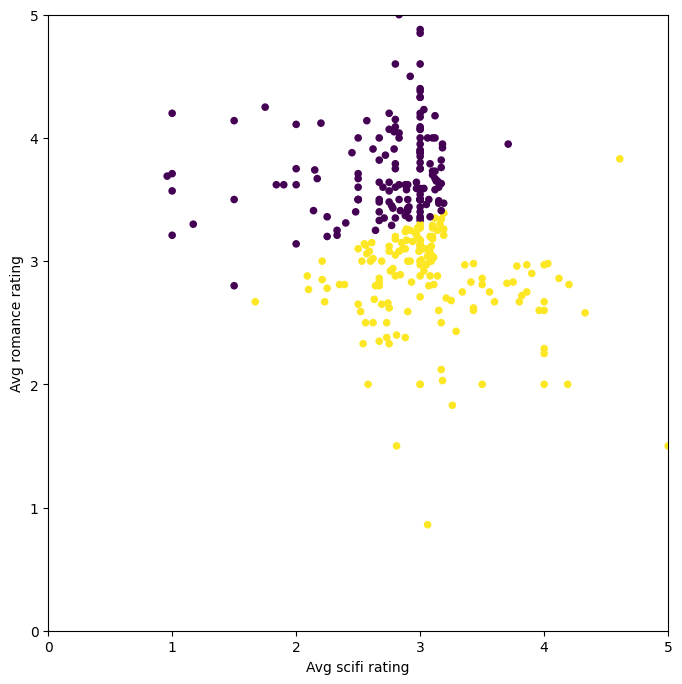

In [13]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

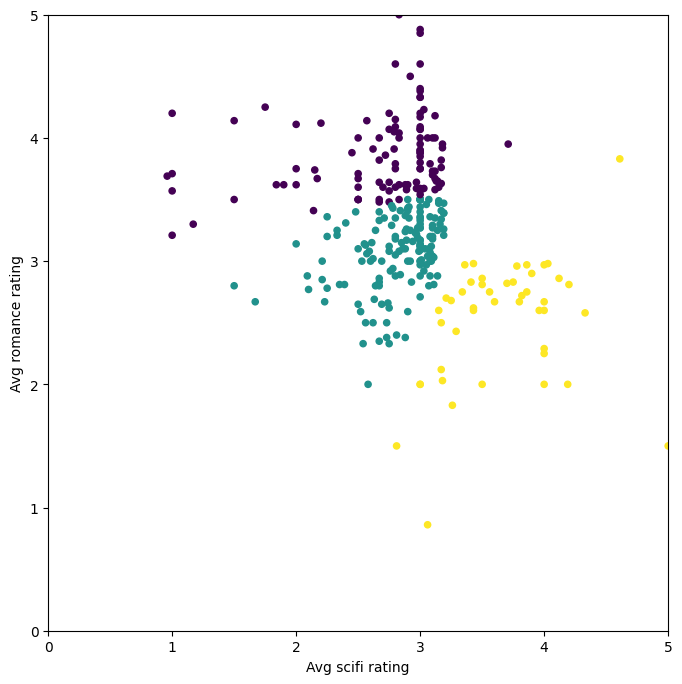

In [16]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

In [70]:
# Przycinanie tabeli na podstawie popularności filmów
# Obliczanie liczby ocen dla każdego filmu
movie_counts = ratings['movieId'].value_counts()

# Lista najpopularniejszych filmów (np. 1000 najpopularniejszych)
top_movies = movie_counts.head(1000) #.index.tolist()

# Przycinanie do najpopularniejszych filmów
ratings_pruned = ratings[ratings['movieId'].isin(top_movies)]


In [25]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings_pruned, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (138475, 1000) 

Subset example:


title   (500) Days of Summer (2009)  10 Things I Hate About You (1999)  \
userId                                                                   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   
5                               NaN                                NaN   
6                               NaN                                NaN   

title   101 Dalmatians (1996)  \
userId                          
1                         NaN   
2                         NaN   
3                         NaN   
4                         NaN   
5                         NaN   
6                         NaN   

title   101 Dalmatians (One Hundred and One Dalmatians) (1961)  \
userId                                                           
1                                                     NaN        
2                                                     NaN        
3                                                     NaN        
4                                                     NaN        
5                                                     NaN        
6                                                     NaN        

title   12 Angry Men (1957)  13th Warrior, The (1999)  \
userId                                                  
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   
5                       NaN                       NaN   
6                       NaN                       NaN   

title   20,000 Leagues Under the Sea (1954)  2001: A Space Odyssey (1968)  \
userId                                                                      
1                                       NaN                           3.5   
2                                       NaN                           5.0   
3                                       NaN                           5.0   
4                                       NaN                           NaN   
5                                       NaN                           NaN   
6                                       NaN                           NaN   

title   21 Grams (2003)  28 Days Later (2002)  
userId                                         
1                   NaN                   3.5  
2                   NaN                   NaN  
3                   NaN                   NaN  
4                   NaN                   NaN  
5                   NaN                   NaN  
6                   NaN                   NaN

In [103]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    count_series = user_movie_ratings.count()
    count_df = pd.DataFrame([count_series.values], columns=count_series.index)
    user_movie_ratings_with_count = pd.concat([user_movie_ratings, count_df], ignore_index=True)
    
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings_with_count.sort_values(len(user_movie_ratings_with_count)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    
    return most_rated_movies

def get_users_who_rate_the_most(user_movie_ratings, max_number_of_users):
    # 1- Count
    user_movie_ratings['total_ratings'] = user_movie_ratings.count(axis=1)
    
    # 2- Sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(by='total_ratings', ascending=False)
    
    # 3- Slice
    users_who_rate_the_most = user_movie_ratings_sorted.iloc[:max_number_of_users, :-1]  # Exclude 'total_ratings' column
    
    return users_who_rate_the_most

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [36]:
# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title  Pulp Fiction (1994)  Forrest Gump (1994)  \
10898                  5.0                  4.5   
7199                   4.5                  2.0   
32525                  5.0                  5.0   
19963                  5.0                  3.5   
66523                  4.5                  4.0   

title  Shawshank Redemption, The (1994)  Silence of the Lambs, The (1991)  \
10898                               4.5                               4.5   
7199                                4.0                               5.0   
32525                               5.0                               5.0   
19963                               5.0                               4.5   
66523                               4.5                               4.5   

title  Jurassic Park (1993)  Star Wars: Episode IV - A New Hope (1977)  \
10898                   5.0                                        5.0   
7199                    4.5                                        3.5   
32525                   5.0                                        5.0   
19963                   2.5                                        4.5   
66523                   3.5                                        5.0   

title  Braveheart (1995)  Terminator 2: Judgment Day (1991)  \
10898                5.0                                4.5   
7199                 3.0                                5.0   
32525                5.0                                4.0   
19963                5.0                                4.5   
66523                4.0                                2.5   

title  Matrix, The (1999)  Schindler's List (1993)  ...  \
10898                 4.5                      4.5  ...   
7199                  1.5                      3.0  ...   
32525                 5.0                      5.0  ...   
19963                 4.5                      4.5  ...   
66523                 5.0                      3.0  ...   

title  Dances with Wolves (1990)  \
10898                        4.0   
7199                         2.0   
32525                        4.0   
19963                        2.5   
66523                        4.0   

title  Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)  \
10898                                                5.0                                
7199                                                 4.5                                
32525                                                5.0                                
19963                                                4.0                                
66523                                                5.0                                

title  Fargo (1996)  Seven (a.k.a. Se7en) (1995)  True Lies (1994)  \
10898           5.0                          5.0               4.0   
7199            4.0                          4.0               4.0   
32525           4.0                          4.0               5.0   
19963           3.5                          4.0               2.0   
66523           2.5                          3.0               3.0   

title  Aladdin (1992)  Speed (1994)  Back to the Future (1985)  \
10898             5.0           4.0                        4.0   
7199              4.5           2.0                        4.0   
32525             4.0           5.0                        5.0   
19963             5.0           1.5                        4.5   
66523             2.5           2.0                        5.0   

title  Godfather, The (1972)  Fight Club (1999)  
10898                    5.0                3.5  
7199                     4.0                3.0  
32525                    5.0                5.0  
19963                    5.0                5.0  
66523                    4.0                5.0  

[5 rows x 30 columns]

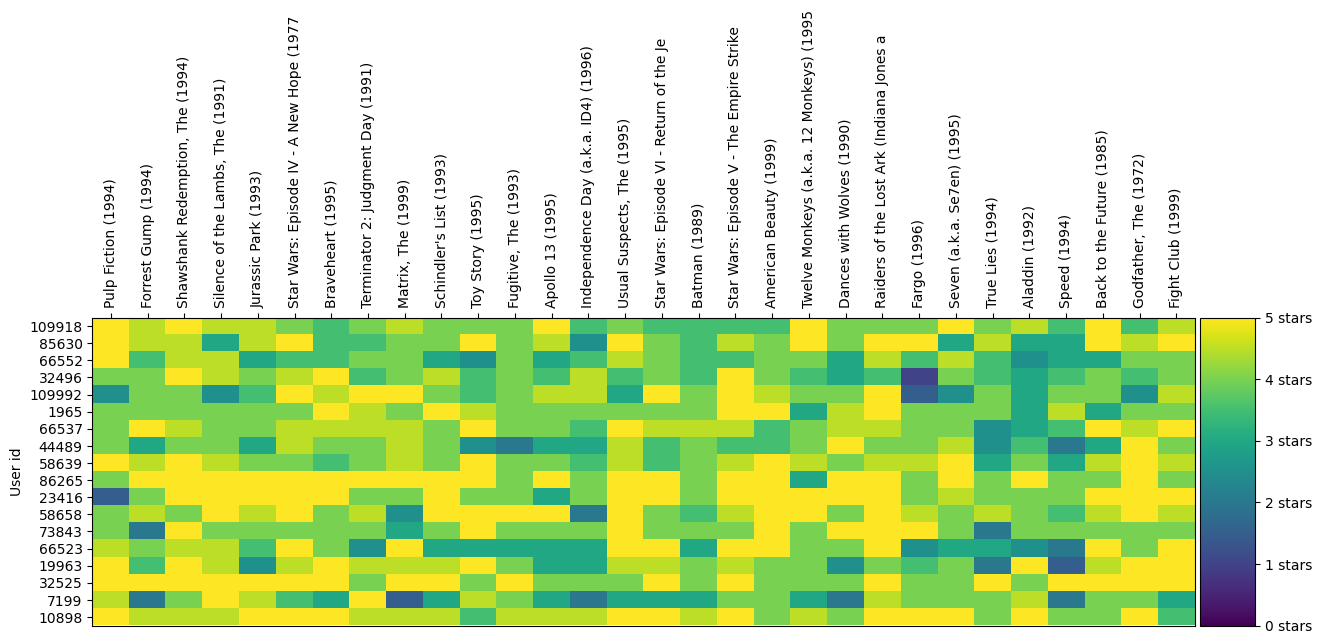

In [37]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
plt.show()
# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [47]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [54]:
type(most_rated_movies_1k)

pandas.core.frame.DataFrame

In [57]:
most_rated_movies_1k

title   Pulp Fiction (1994)  Forrest Gump (1994)  \
0                       4.0                  NaN   
1                       NaN                  NaN   
2                       NaN                  NaN   
3                       NaN                  4.0   
4                       NaN                  NaN   
...                     ...                  ...   
138470                  NaN                  NaN   
138471                  4.0                  NaN   
138472                  NaN                  NaN   
138473                  NaN                  NaN   
138474                  4.5                  5.0   

title   Shawshank Redemption, The (1994)  Silence of the Lambs, The (1991)  \
0                                    4.0                               3.5   
1                                    NaN                               NaN   
2                                    5.0                               5.0   
3                                    NaN                               NaN   
4                                    5.0                               3.0   
...                                  ...                               ...   
138470                               5.0                               4.0   
138471                               NaN                               5.0   
138472                               NaN                               NaN   
138473                               NaN                               NaN   
138474                               NaN                               NaN   

title   Jurassic Park (1993)  Star Wars: Episode IV - A New Hope (1977)  \
0                        NaN                                        4.0   
1                        5.0                                        5.0   
2                        5.0                                        5.0   
3                        4.0                                        NaN   
4                        4.0                                        5.0   
...                      ...                                        ...   
138470                   NaN                                        NaN   
138471                   NaN                                        NaN   
138472                   NaN                                        NaN   
138473                   NaN                                        NaN   
138474                   4.5                                        4.5   

title   Braveheart (1995)  Terminator 2: Judgment Day (1991)  \
0                     NaN                                3.5   
1                     4.0                                5.0   
2                     NaN                                4.0   
3                     NaN                                4.0   
4                     4.0                                5.0   
...                   ...                                ...   
138470                NaN                                NaN   
138471                4.0                                NaN   
138472                NaN                                NaN   
138473                NaN                                NaN   
138474                3.0                                NaN   

title   Matrix, The (1999)  Schindler's List (1993)  ...  \
0                      NaN                      NaN  ...   
1                      NaN                      NaN  ...   
2                      5.0                      NaN  ...   
3                      NaN                      NaN  ...   
4                      NaN                      NaN  ...   
...                    ...                      ...  ...   
138470                 4.0                      NaN  ...   
138471                 NaN                      NaN  ...   
138472                 NaN                      NaN  ...   
138473                 5.0                      NaN  ...   
138474                 4.5                      5.0  ...   

title   Monster's Ball (2001)  American Gangste

In [55]:
# Conversion to sparse csr matrix
#sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())
sparse_ratings = csr_matrix(most_rated_movies_1k)

In [56]:
sparse_ratings

<138475x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 138475000 stored elements in Compressed Sparse Row format>

In [42]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(top_movies)

In [43]:
sparse_ratings

<1x1000 sparse matrix of type '<class 'numpy.intc'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [63]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix

# Impute NaN values with mean
imputer = SimpleImputer(strategy='mean')
sparse_ratings_imputed = imputer.fit_transform(sparse_ratings)

In [64]:
sparse_ratings_imputed

<138475x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 138475000 stored elements in Compressed Sparse Column format>

In [65]:
# 20 clusters
predictions = KMeans(n_clusters=20).fit_predict(sparse_ratings_imputed)

NameError: name 'most_rated_movies' is not defined

In [78]:
def draw_movie_clusters(clustered, max_users, max_movies):
    n_clusters = clustered['group'].nunique()
    
    # Create a figure and subplots
    fig, axes = plt.subplots(n_clusters, 1, figsize=(20, 4 * n_clusters))
    
    # Iterate over clusters and draw heatmap
    for i, (group_idx, group) in enumerate(clustered.groupby('group')):
        most_rated_movies_users_selection = group.drop(columns=['group']).reset_index(drop=True)
        ax = axes[i]
        draw_movies_heatmap(most_rated_movies_users_selection, ax)
        ax.set_title(f"Cluster {i}")
    
    plt.tight_layout()
    plt.show()

C:\Users\sebap\AppData\Local\Temp\ipykernel_10800\1096805895.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15,4))


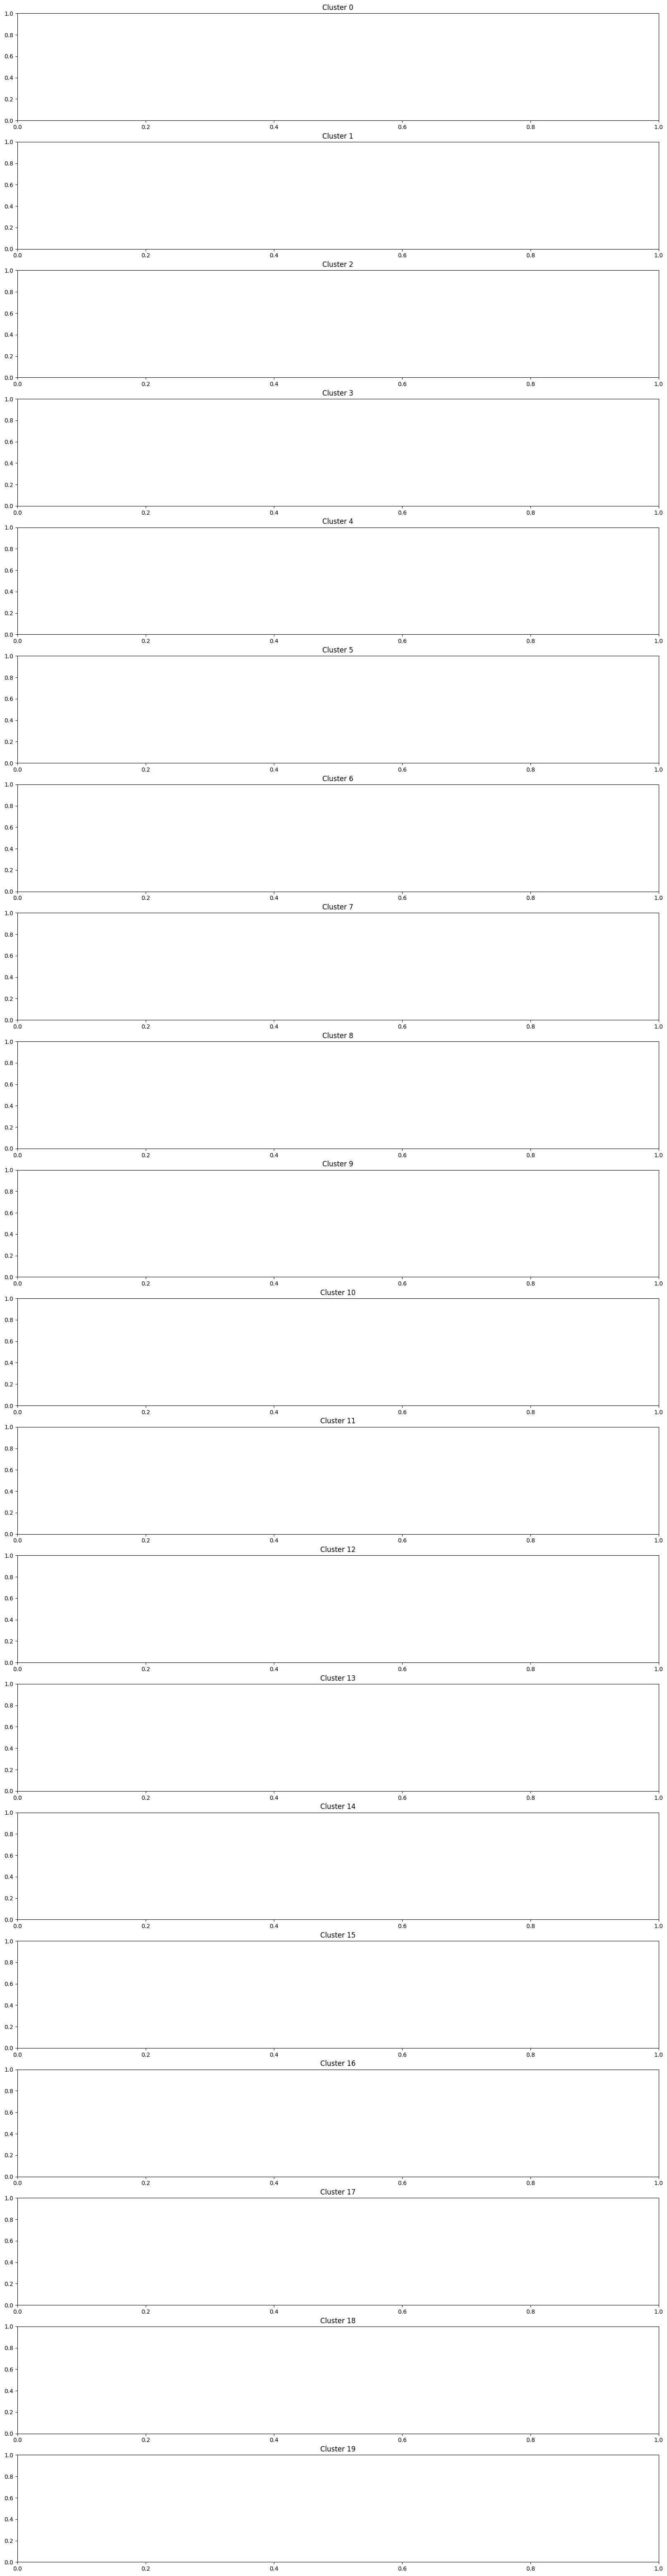

KeyboardInterrupt: 

In [82]:
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [83]:
clustered

index  Pulp Fiction (1994)  Forrest Gump (1994)  \
0            0                  4.0                  NaN   
1            1                  NaN                  NaN   
2            2                  NaN                  NaN   
3            3                  NaN                  4.0   
4            4                  NaN                  NaN   
...        ...                  ...                  ...   
138470  138470                  NaN                  NaN   
138471  138471                  4.0                  NaN   
138472  138472                  NaN                  NaN   
138473  138473                  NaN                  NaN   
138474  138474                  4.5                  5.0   

        Shawshank Redemption, The (1994)  Silence of the Lambs, The (1991)  \
0                                    4.0                               3.5   
1                                    NaN                               NaN   
2                                    5.0                               5.0   
3                                    NaN                               NaN   
4                                    5.0                               3.0   
...                                  ...                               ...   
138470                               5.0                               4.0   
138471                               NaN                               5.0   
138472                               NaN                               NaN   
138473                               NaN                               NaN   
138474                               NaN                               NaN   

        Jurassic Park (1993)  Star Wars: Episode IV - A New Hope (1977)  \
0                        NaN                                        4.0   
1                        5.0                                        5.0   
2                        5.0                                        5.0   
3                        4.0                                        NaN   
4                        4.0                                        5.0   
...                      ...                                        ...   
138470                   NaN                                        NaN   
138471                   NaN                                        NaN   
138472                   NaN                                        NaN   
138473                   NaN                                        NaN   
138474                   4.5                                        4.5   

        Braveheart (1995)  Terminator 2: Judgment Day (1991)  \
0                     NaN                                3.5   
1                     4.0                                5.0   
2                     NaN                                4.0   
3                     NaN                                4.0   
4                     4.0                                5.0   
...                   ...                                ...   
138470                NaN                                NaN   
138471                4.0                                NaN   
138472                NaN                                NaN   
138473                NaN                                NaN   
138474                3.0                                NaN   

        Matrix, The (1999)  ...  American Gangster (2007)  Logan's Run (1976)  \
0                      NaN  ...                       NaN                 NaN   
1                      NaN  ...                       NaN                 NaN   
2                      5.0  ...                       NaN                 4.0   
3                      NaN  ...                       NaN                 NaN   
4                      NaN  ...                       NaN                 NaN   
...                    ...  ...                       ...                 ...   
138470                 4.0  ...                       NaN                 NaN   
138471                 NaN  ...  

In [85]:
# W grupie 8 jest 309 osób 
group8 = clustered[clustered["group"] == 8]

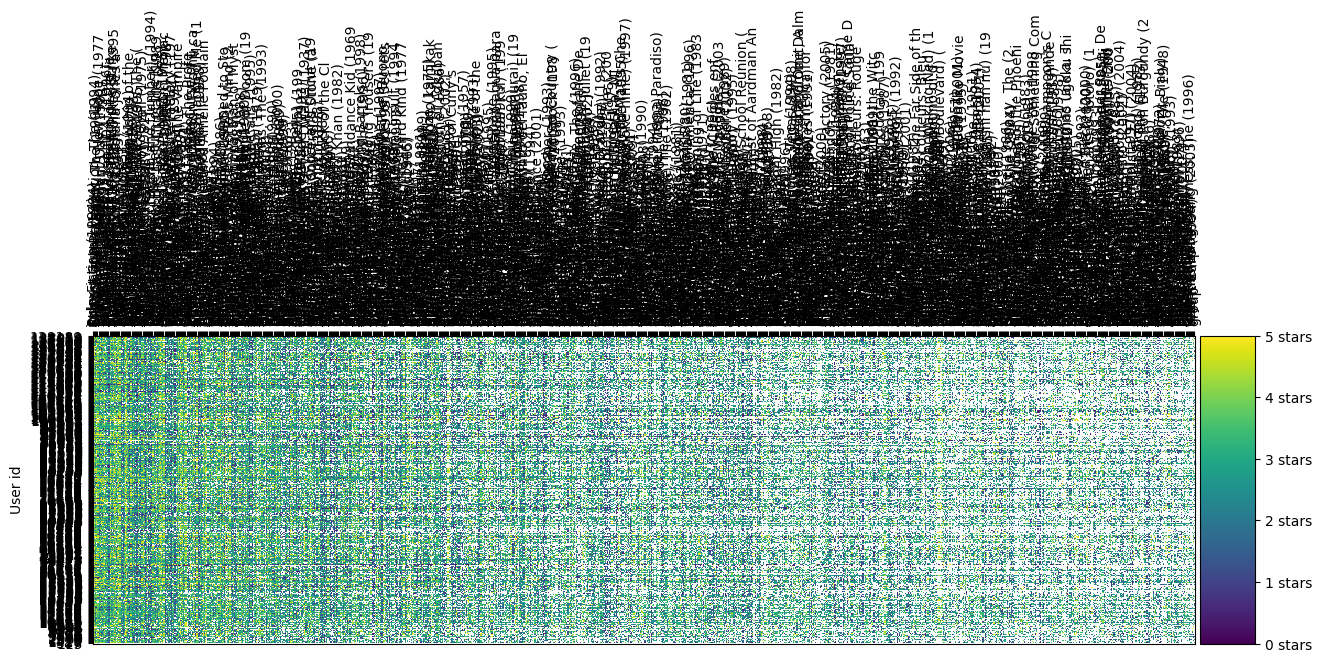

In [87]:
# Wyświetlenie wszystkiego na raz nie jest szczególnie czytelne. 
draw_movies_heatmap(group8)

In [91]:
# Należy ograniczyć do użytkowników, którzy dali najwięcej opinii i filmów, które były najczęściej oceniane w tej grupie 
wybrane = group8.drop(columns = ['group', 'index'])
wybrane = sort_by_rating_density(wybrane, 20, 50)

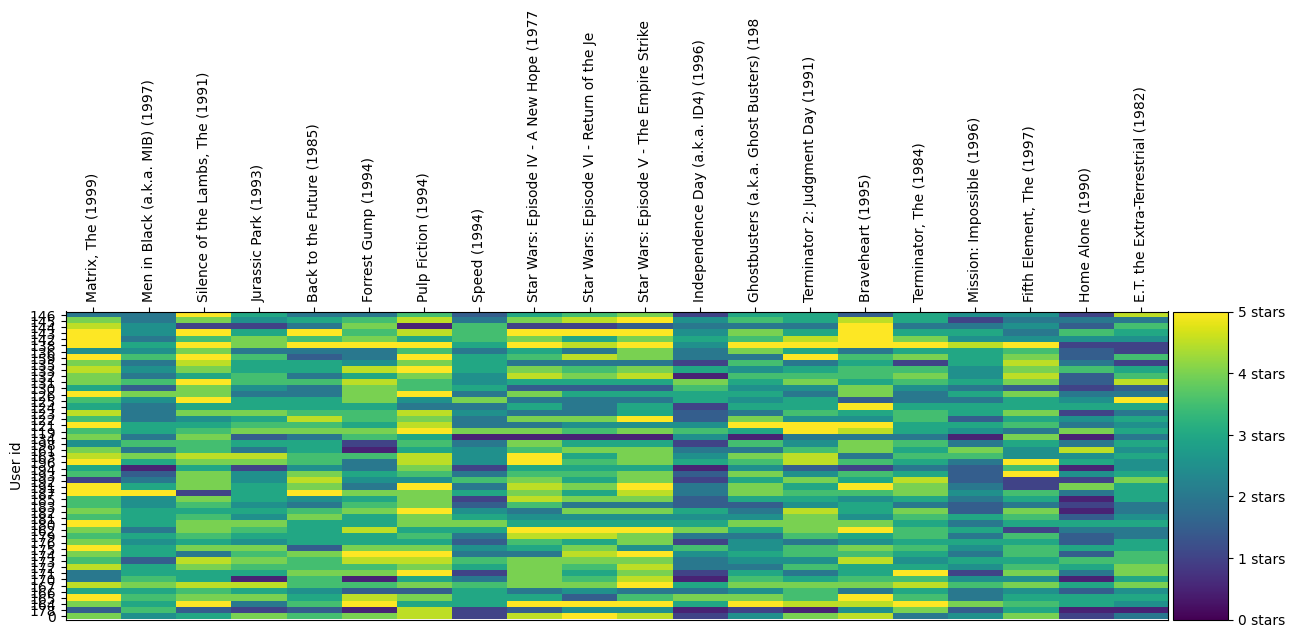

In [92]:
draw_movies_heatmap(wybrane)

## Wnioski z otrzymanej heatmapy
Podobieństwo kolorów w kolumnach wskazuje na podobieństwo gustów użytkowników. Widać wyraźnie że użytkownikom z grupy 8 nie podobał się film "Independence day" za to wszystkim wyraźnie podobał się film "Pulp Fiction"
Porównajmy to jeszcze z inną grupą

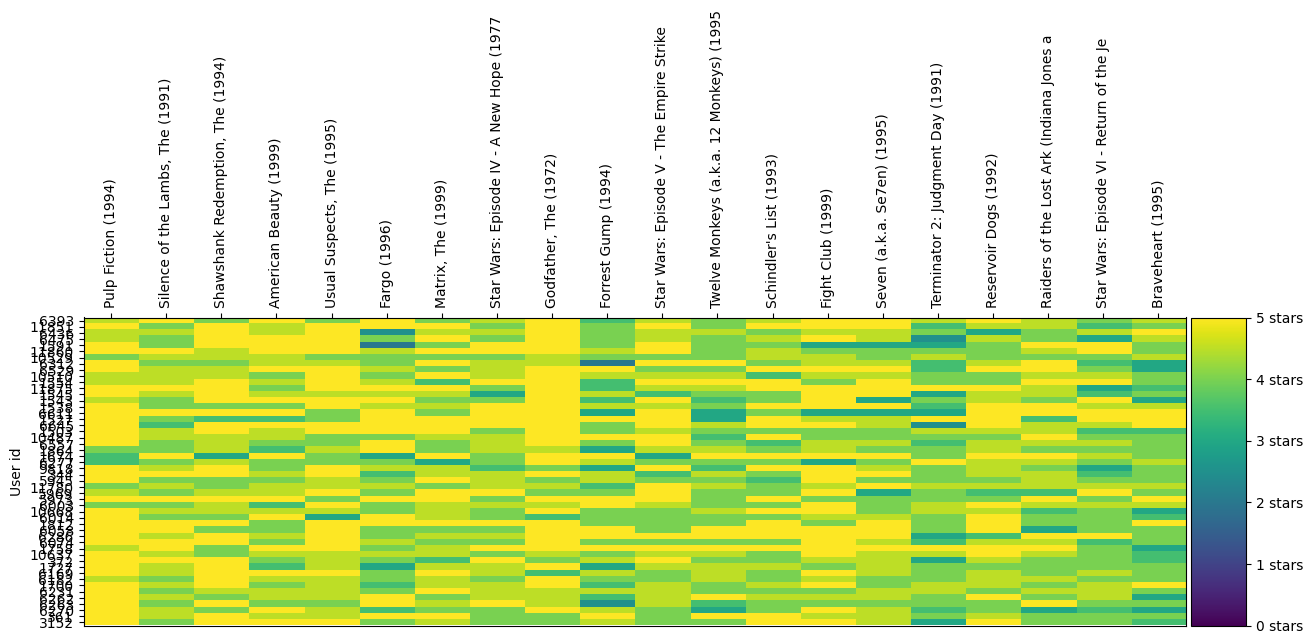

In [96]:
group12 = clustered[clustered["group"] == 12]
wybrane12 = group12.drop(columns = ['group', 'index'])
wybrane12 = sort_by_rating_density(wybrane12, 20, 50)
draw_movies_heatmap(wybrane12)

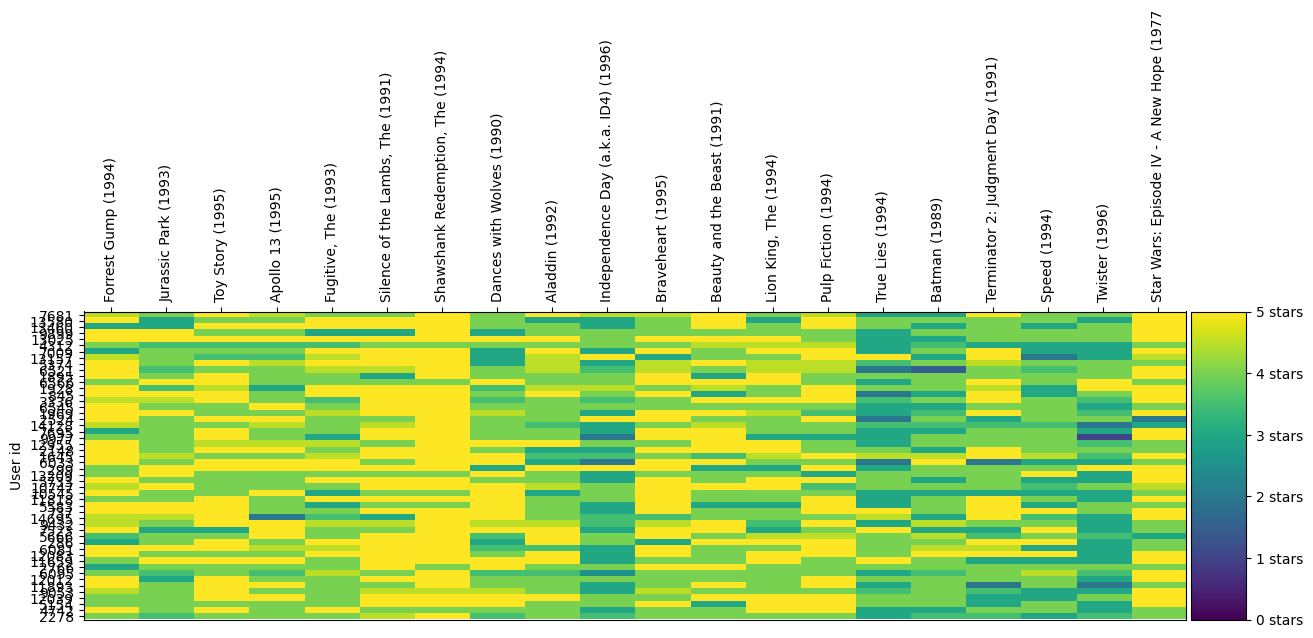

In [95]:
group14 = clustered[clustered["group"] == 14]
wybrane14 = group14.drop(columns = ['group', 'index'])
wybrane14 = sort_by_rating_density(wybrane14, 20, 50)
draw_movies_heatmap(wybrane14)

## Wnioski z trzech heatmap
Grupa 14 zdaje się być użytkownikami, ktorzy generalnie lepiej oceniają obejrzane filmy. Independence day to słaby film

In [113]:
# Zmieniam tą funkcję, żeby każda heatmapa miała kolumny w takiej samej kolejności, wtedy łatwiej znaleźć różnice między grupami

def sort_by_rating_density_changed(user_movie_ratings, n_movies, n_users, popularne_filmy):
    tylko_popularne_filmy = user_movie_ratings[popularne_filmy.columns].copy()  # Użyj .copy() tutaj
    gesta_czesc = get_users_who_rate_the_most(tylko_popularne_filmy, n_users)
    return gesta_czesc

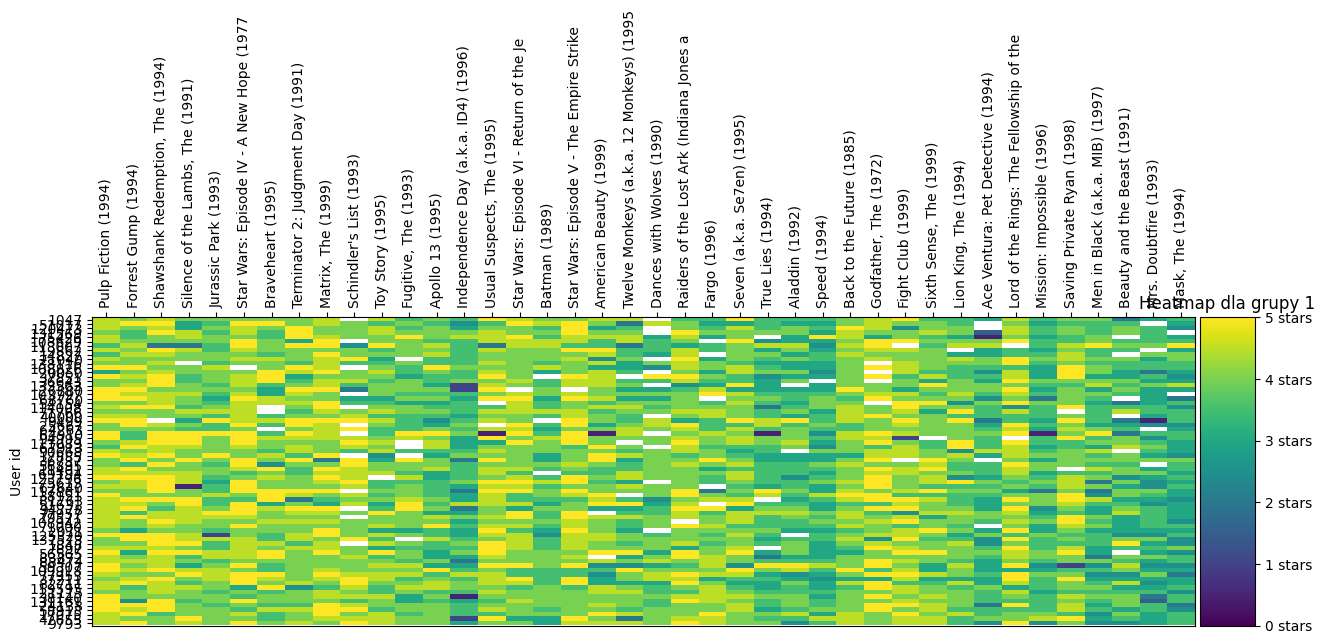

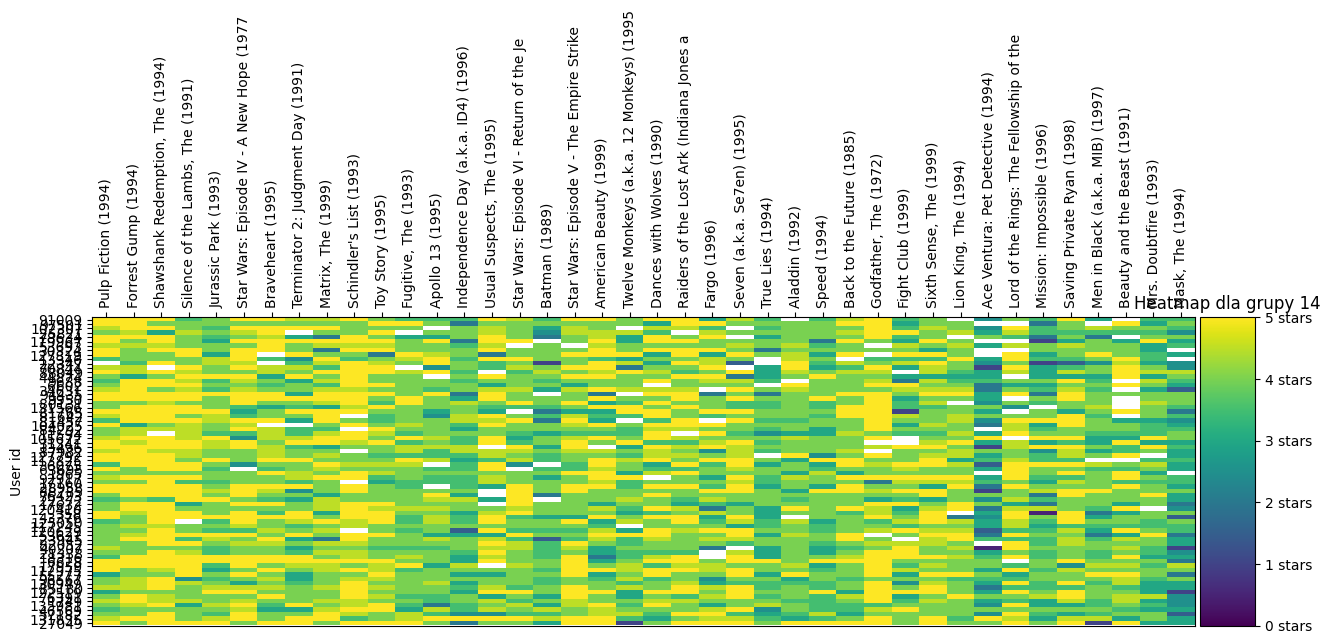

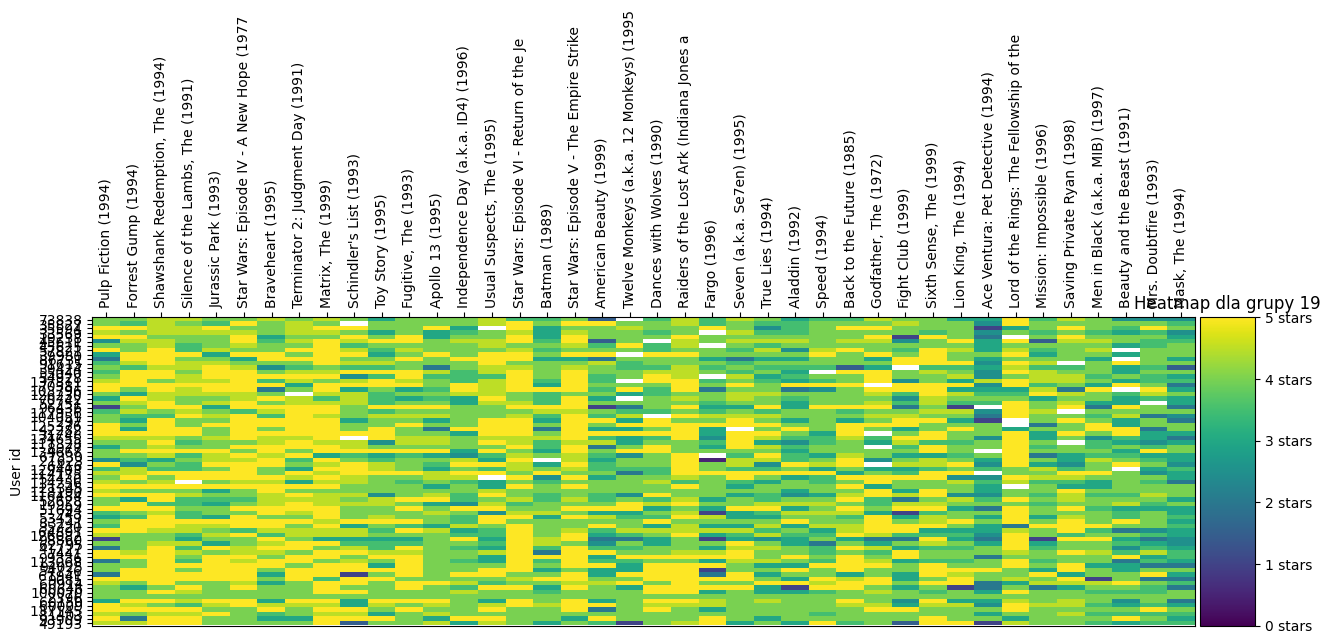

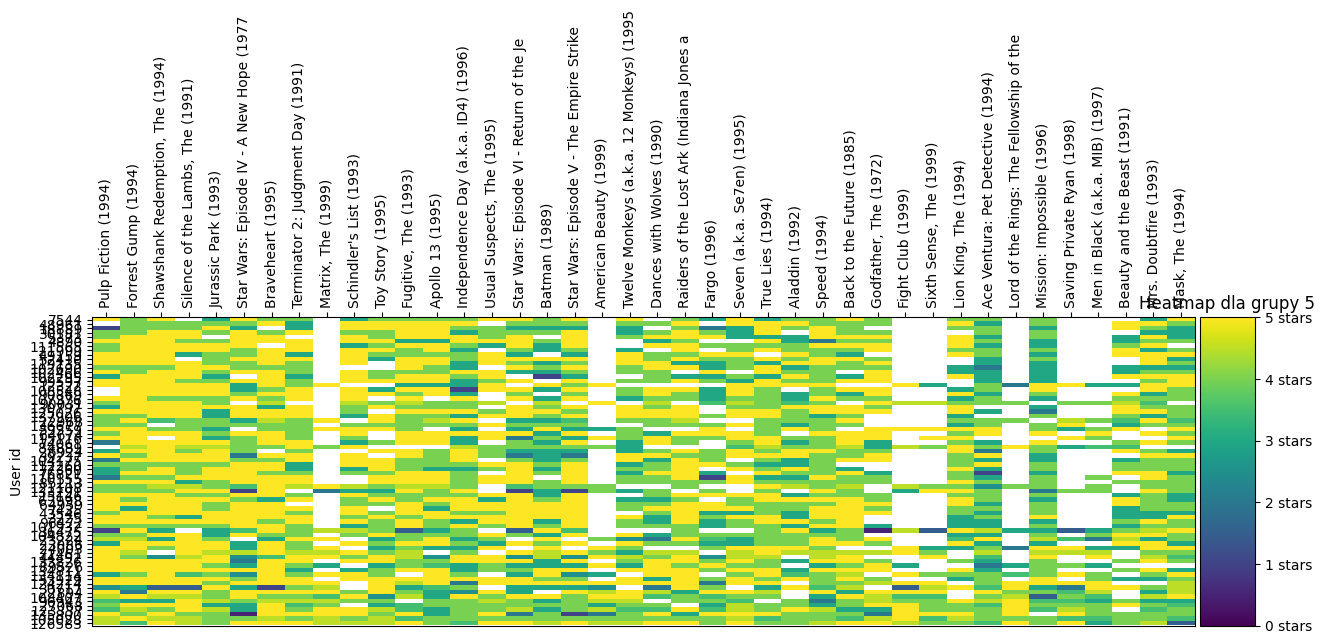

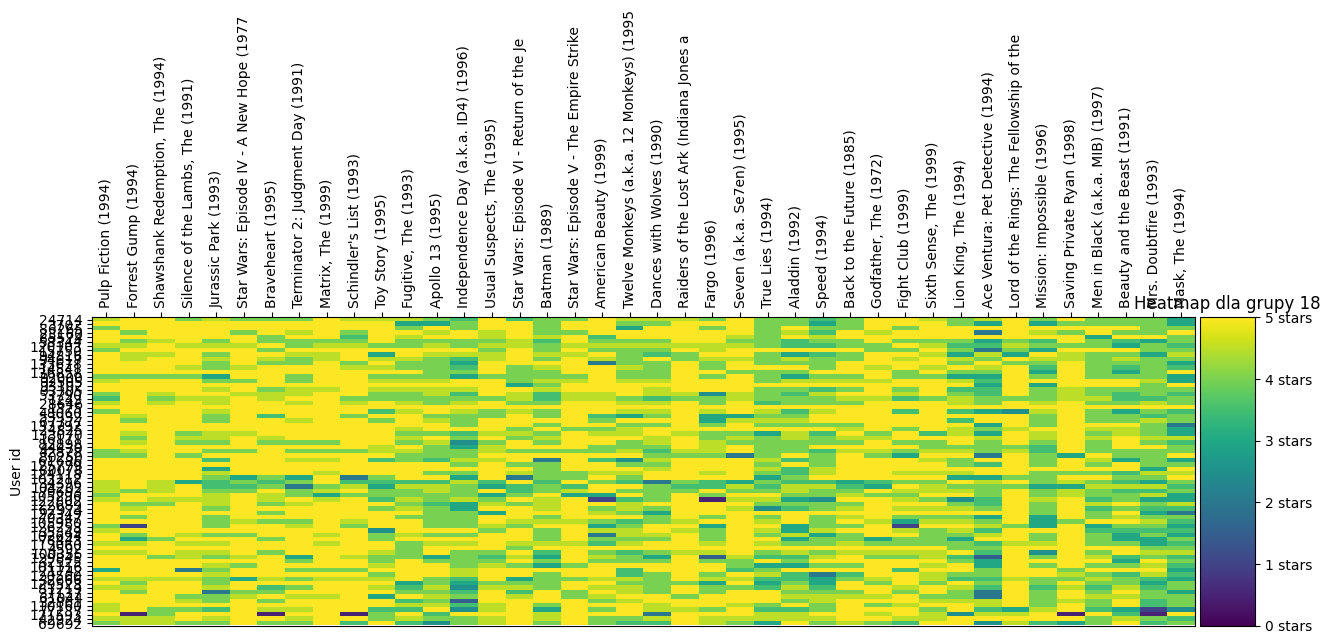

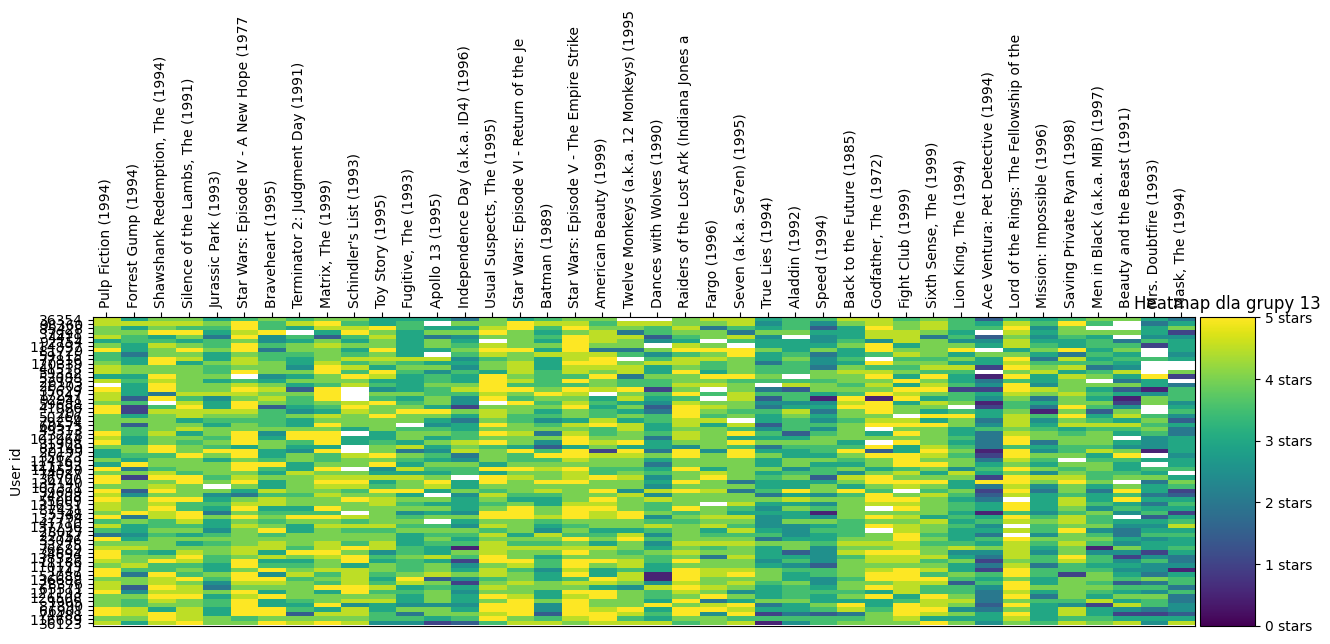

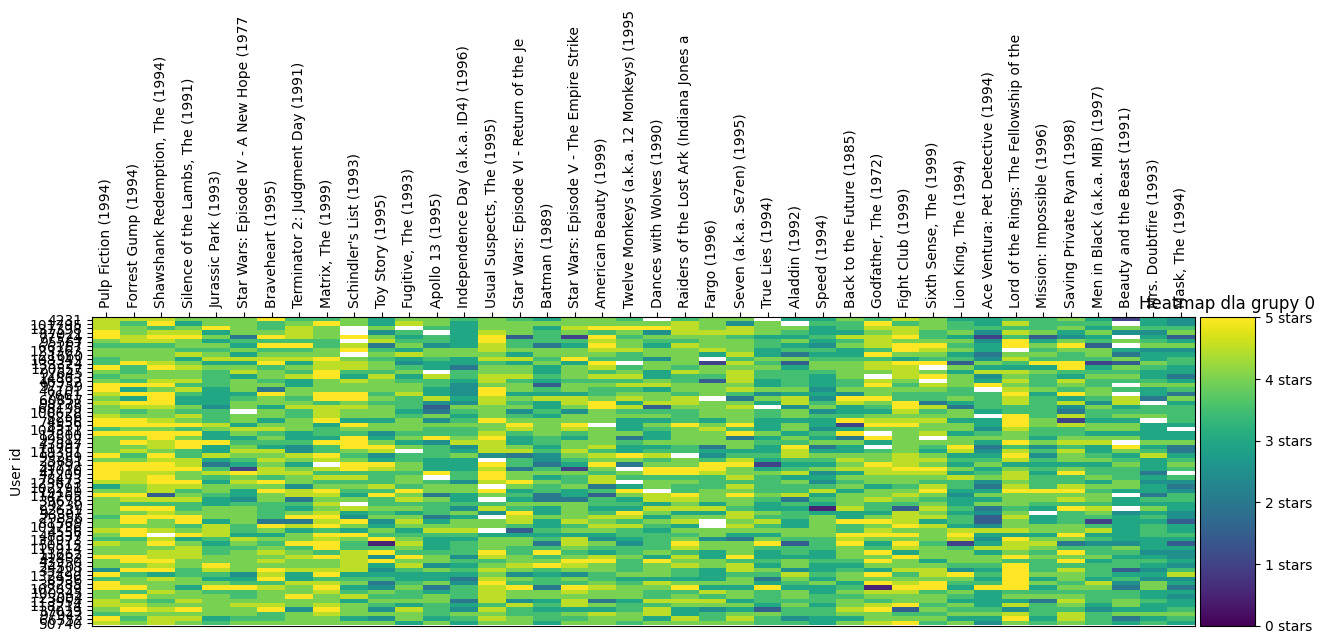

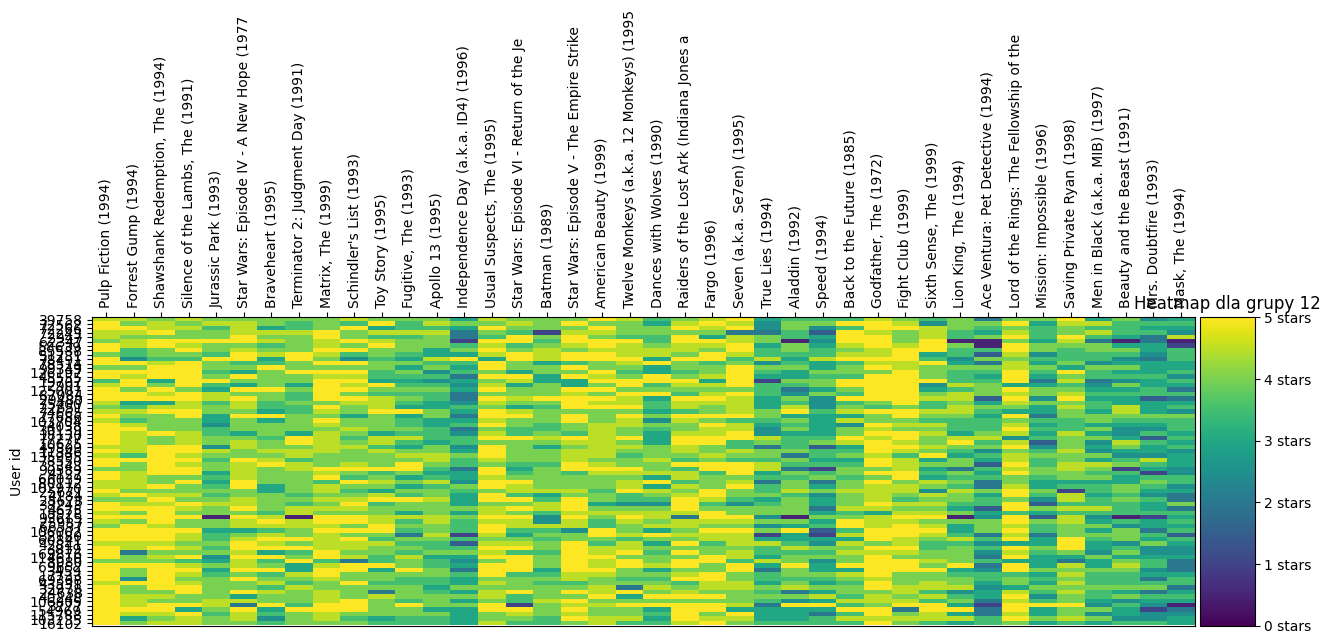

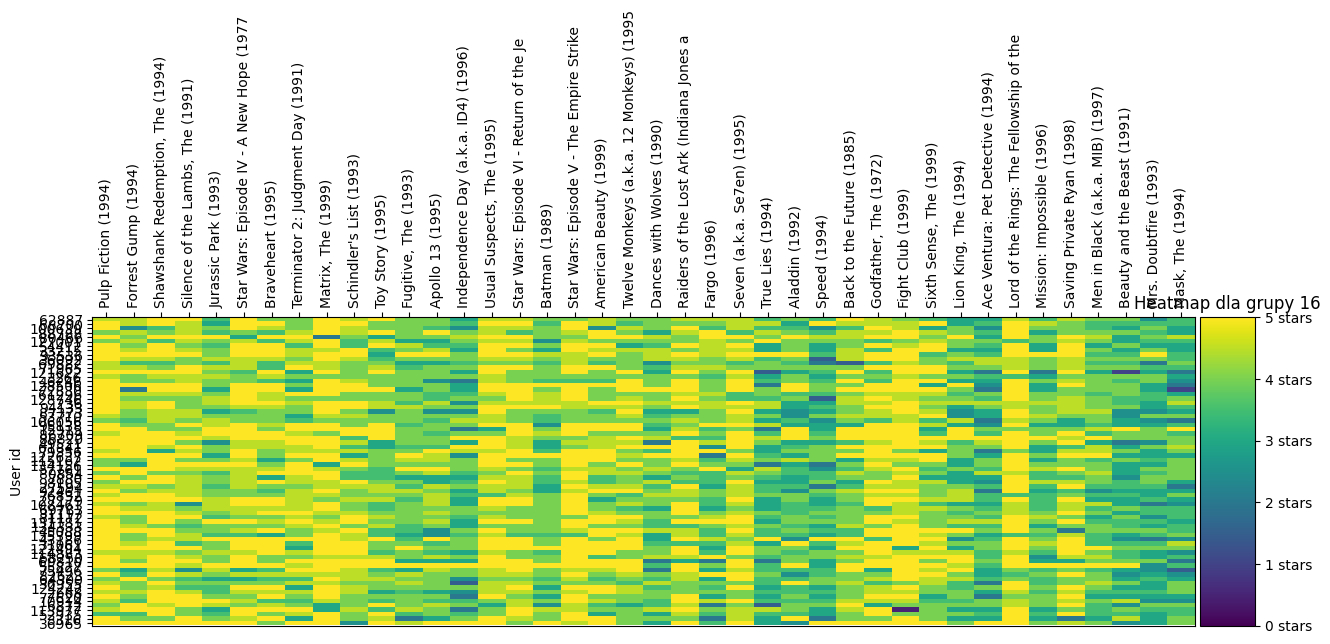

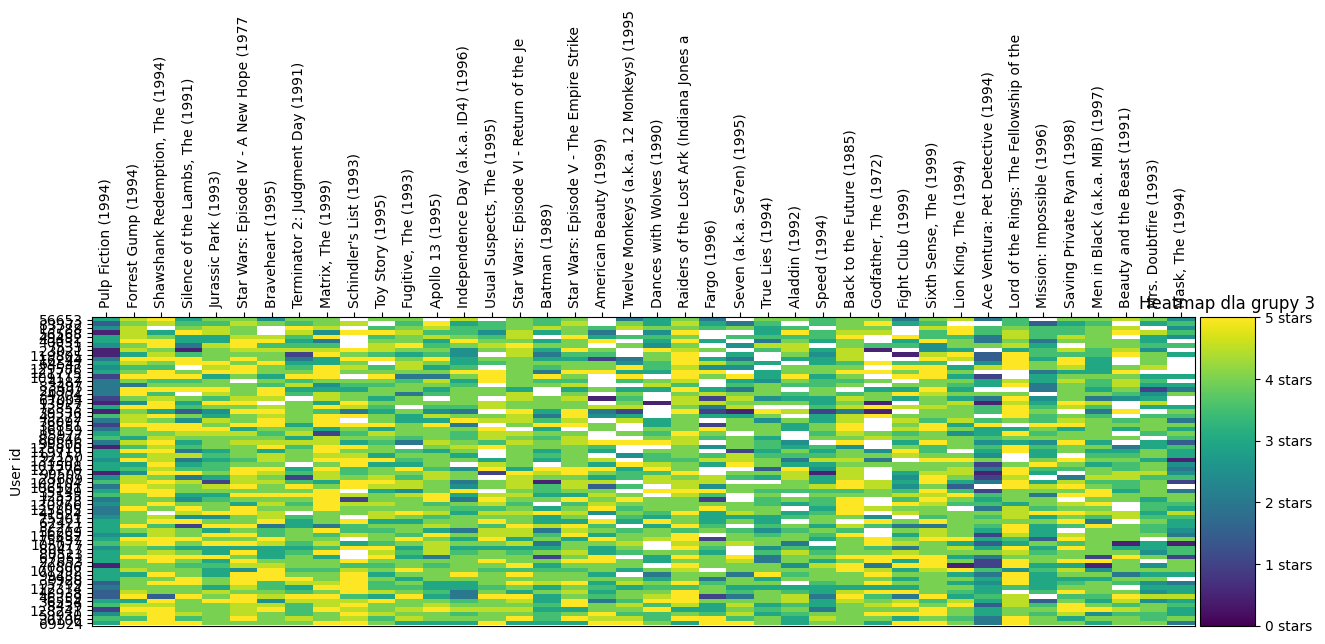

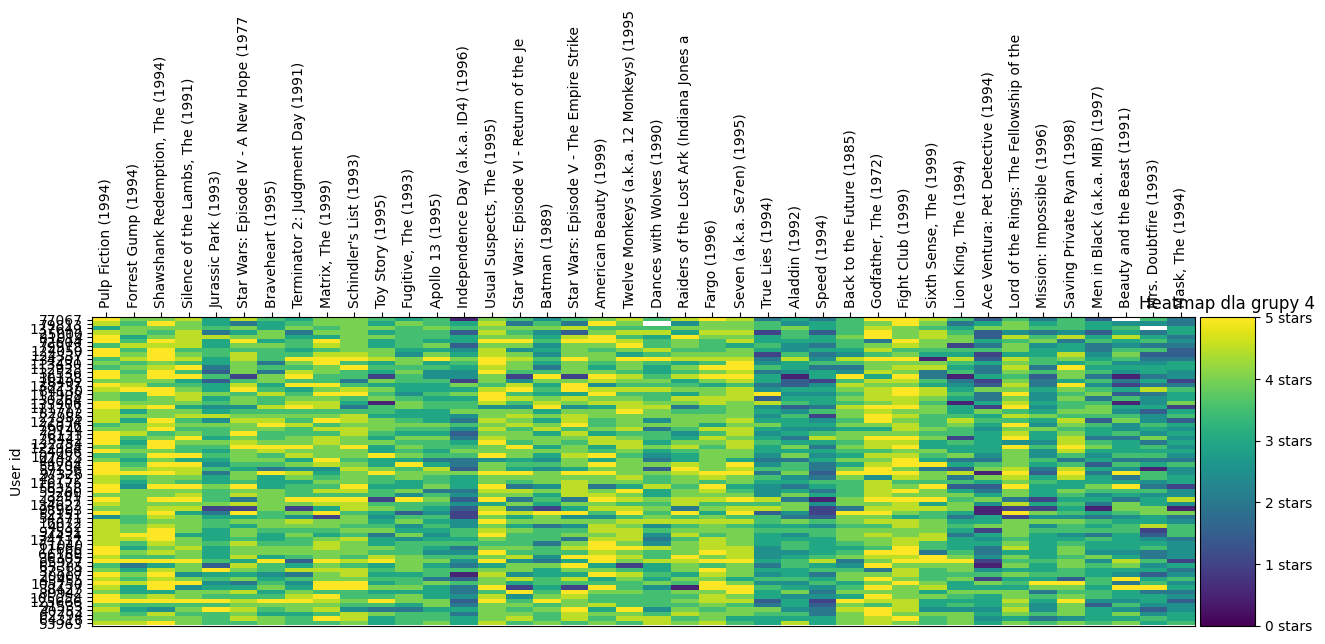

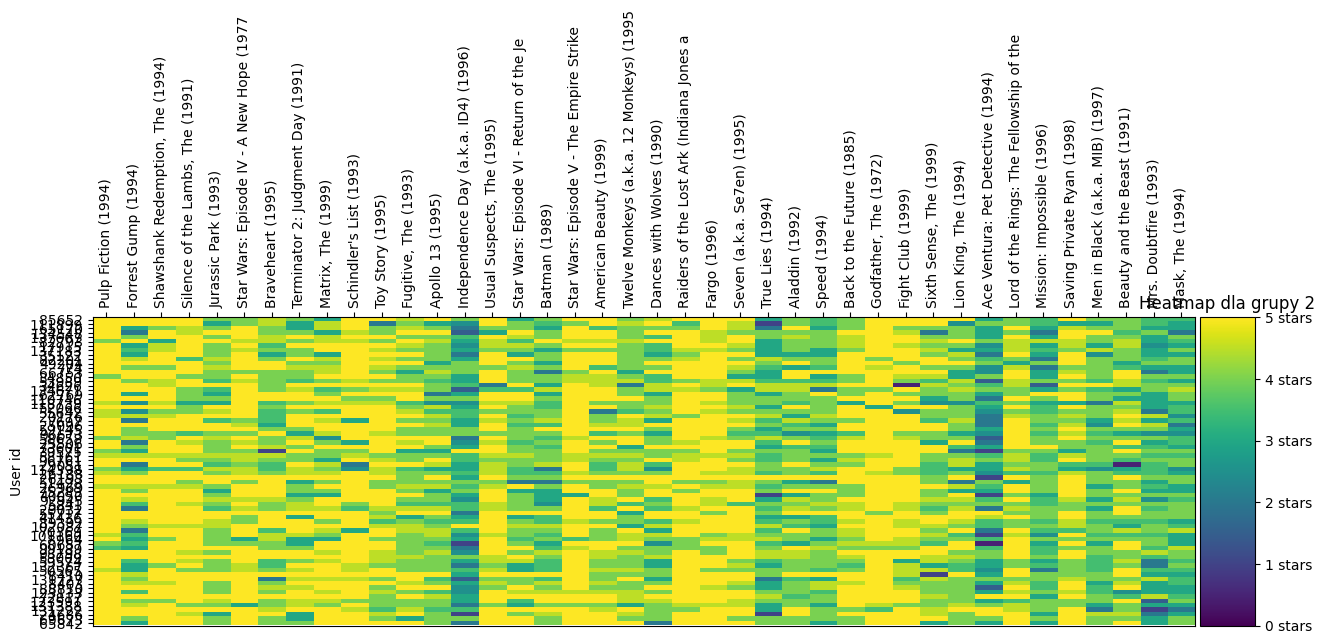

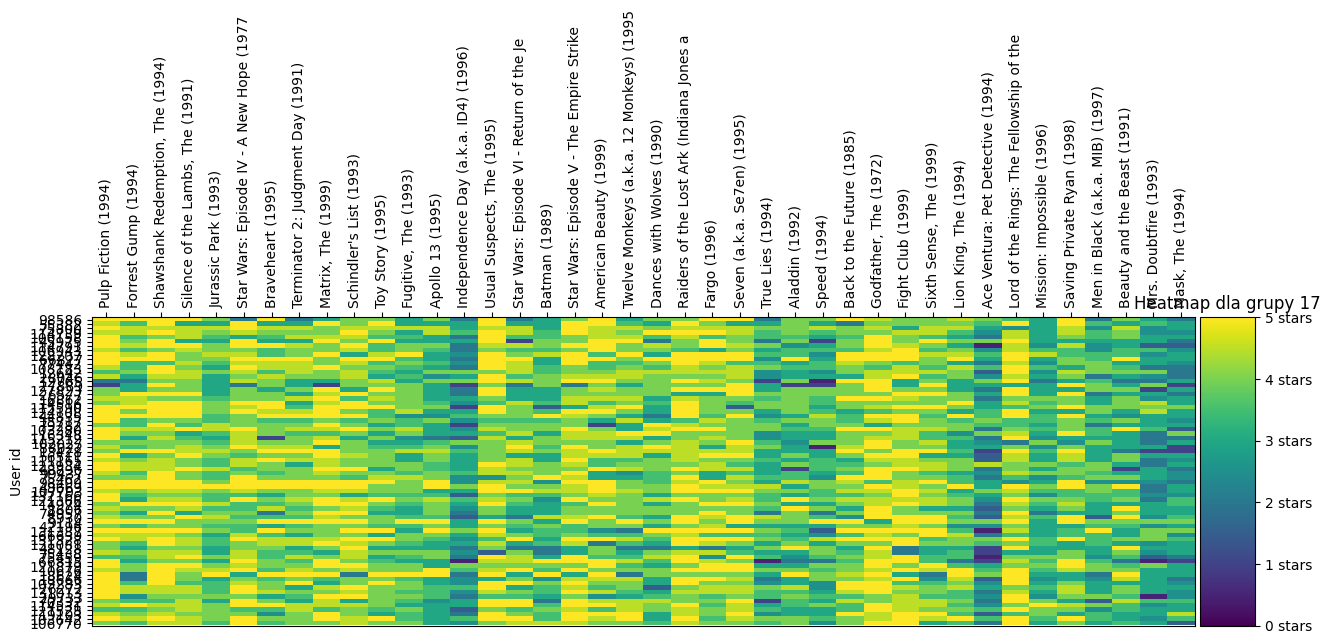

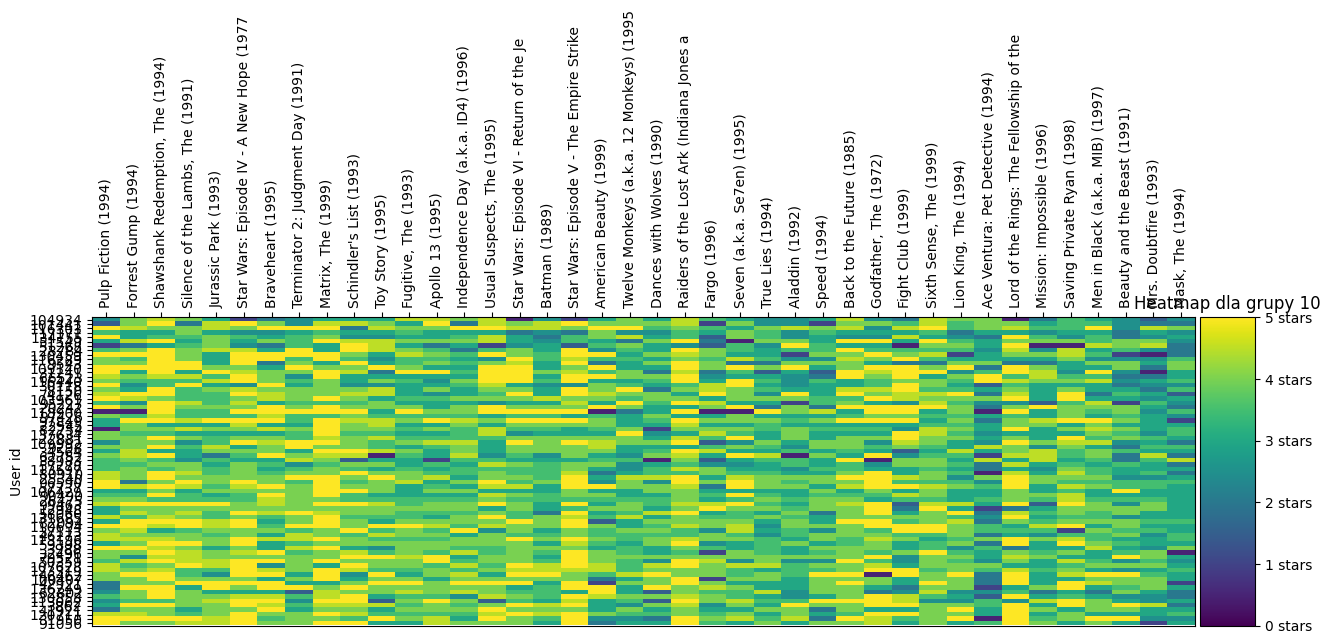

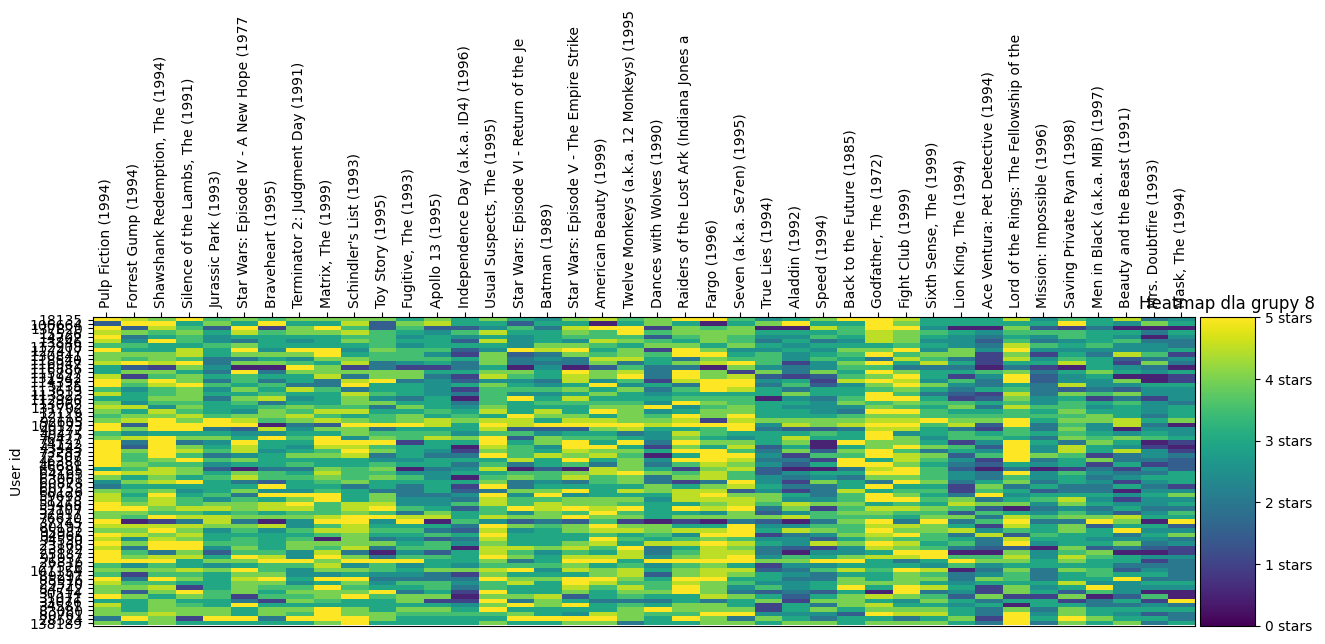

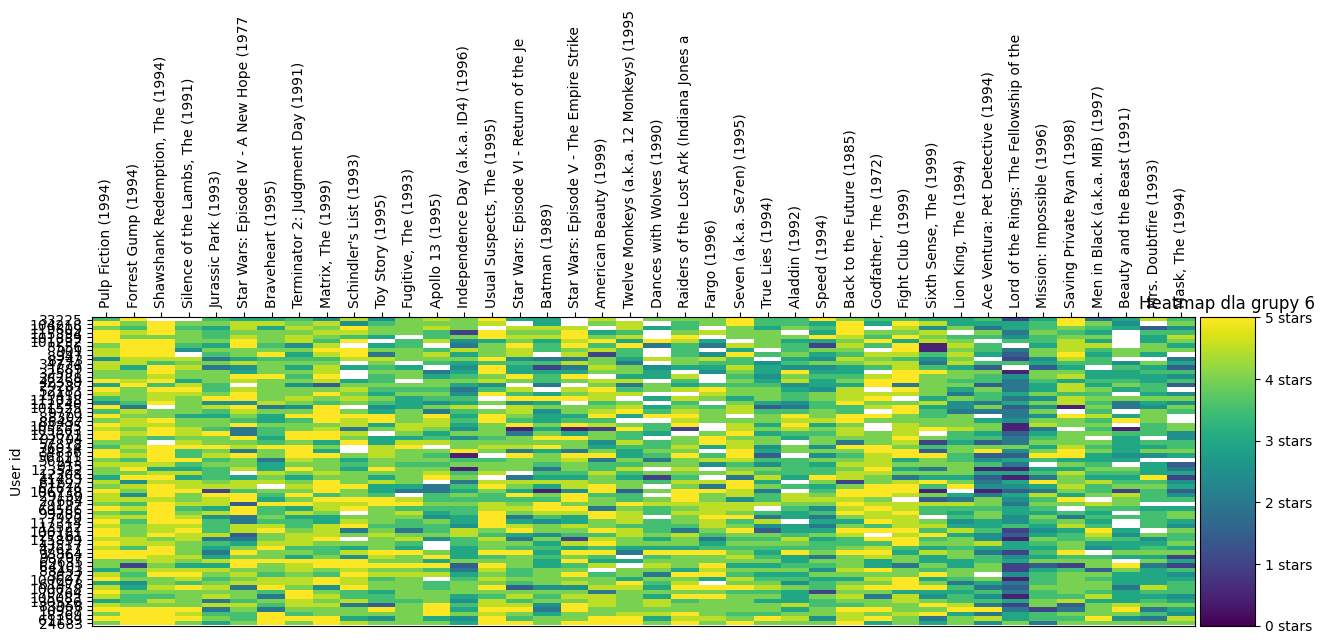

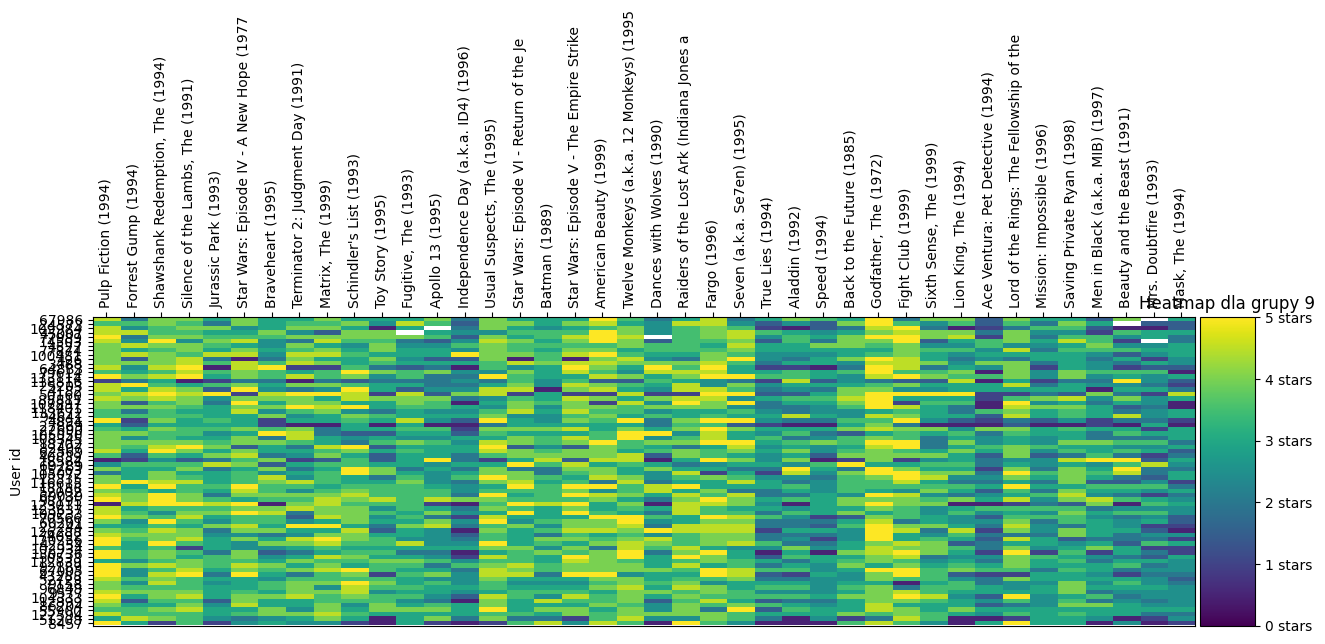

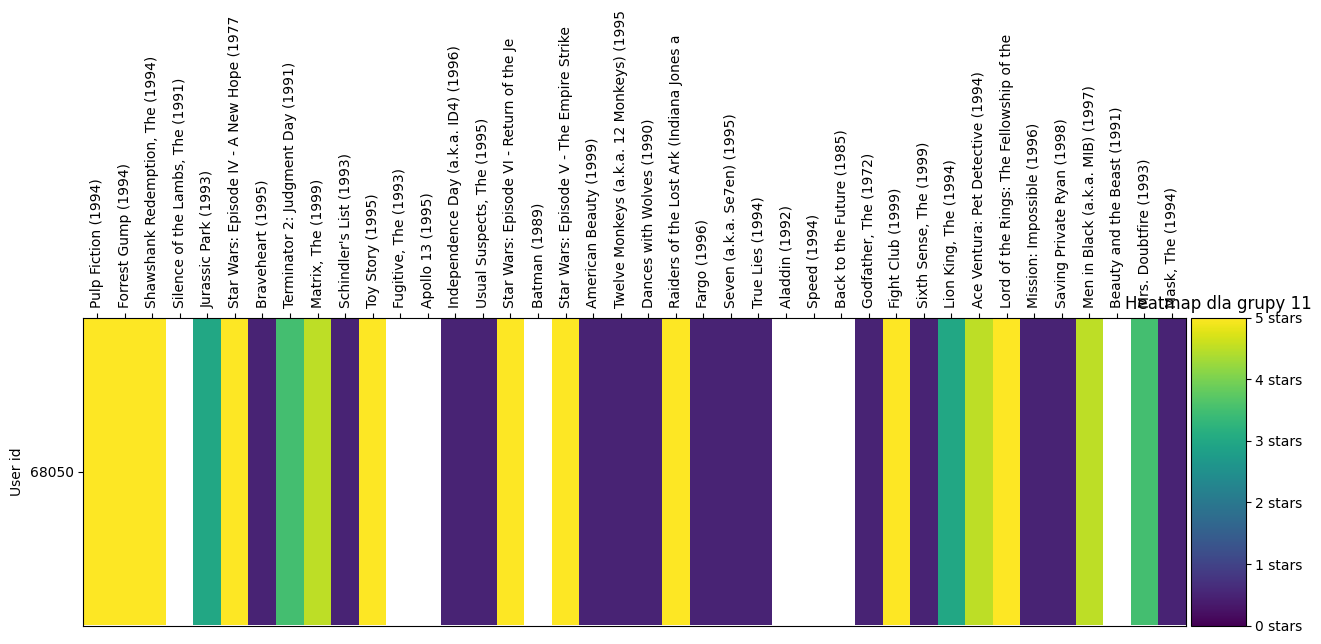

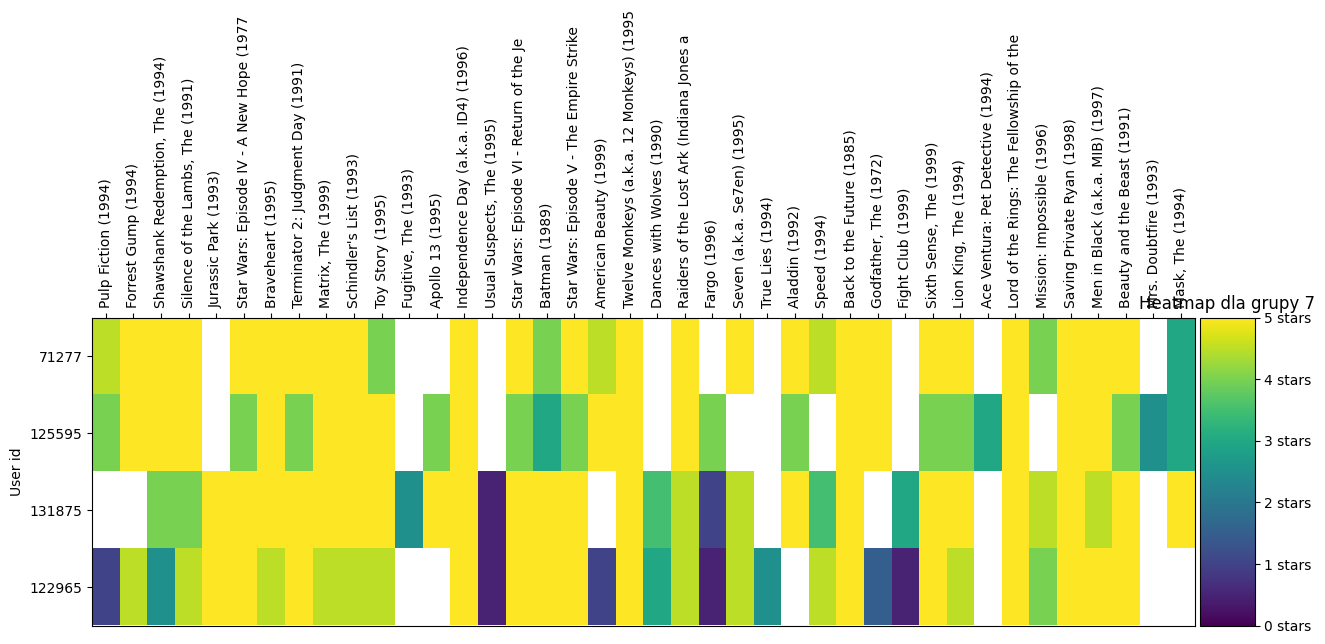

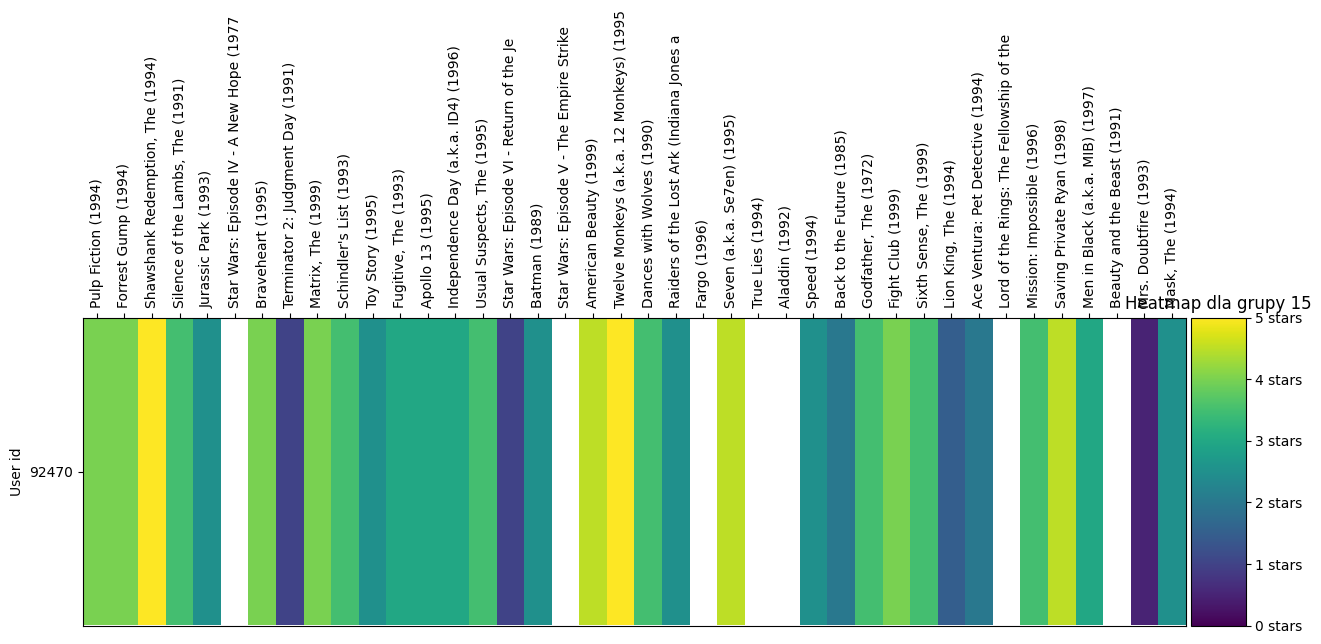

In [115]:
# Funkcja do narysowania heatmap dla wszystkich grup
def draw_heatmaps_for_groups(clustered, n_movies, n_users, most_rated_movies_1k):
    unique_groups = clustered['group'].unique()

    popularne_filmy = get_most_rated_movies(most_rated_movies_1k, n_movies)
    
    for group in unique_groups:
        # Wybierz grupę
        group_data = clustered[clustered['group'] == group].copy()  # Użyj .copy() tutaj
        
        # Usuń niepotrzebne kolumny i posortuj dane
        selected_data = group_data.drop(columns=['group', 'index'])
        selected_data = sort_by_rating_density_changed(selected_data, n_movies, n_users, popularne_filmy)
        
        # Narysuj heatmapę
        draw_movies_heatmap(selected_data)
        plt.title(f'Heatmap dla grupy {group}')
        plt.show()


# Użyj funkcji
draw_heatmaps_for_groups(clustered, 40, 70, most_rated_movies_1k)
